In [17]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import cvxpy as cp
from numpy import linalg as LA
import pprint
from lap import lapjv
import copy
import sys
import datetime
from tqdm import tqdm_notebook

print(sys.getrecursionlimit())
sys.setrecursionlimit(50000)

N = [18,22,26,30,34,38,42,46,50,54,58,62,66]
ro = 0.8
a = 0.2
k = 10

num_loop = 1000


50000


In [2]:
# Construct K
def K_Bernoulli(n,a):
    np.random.seed(3)
    K=np.identity(n)
    P=np.ones([n,n]) 
    K = P-K
    #print(K)
    for i in range(n):
        for j in range(i+1,n):
            K[i][j] = round(random.uniform(a,1-a),2)
            #K[i][j] = random.uniform(alpha,1-alpha)
            K[j][i]=K[i][j]        
    return K
     

# Generate A
def A_adj(K):
    n = len(K)
    B=np.identity(len(K))
    P=np.ones([n,n]) 
    #print(P)
    B= P-B
    #print(B)
    for i in range(len(B)):
        for j in range(i+1,len(B)):
            B[i][j] =random.uniform(0,1)
            if B[i][j] < K[i][j]:
                B[i][j] = 1
            else:
                B[i][j] = 0
            B[j][i] = B[i][j]
    A = B
    return A

# Generate B
def B_adj(ro,K,A):
    B = np.zeros([len(A),len(A)])
    for i in range(len(B)):
        for j in range(i+1,len(B)):
            B[i][j] =random.uniform(0,1)
            if B[i][j] < (1-ro)*K[i][j] + ro*A[i][j]:
                B[i][j] = 1
            else:
                B[i][j] = 0
            B[j][i] = B[i][j]
    return B
    
    
                
            
                
            


In [3]:
#Construct a n-degree permutation matrix 

def permu(N):
    E=np.identity(N)
    permutation = np.random.permutation(N)
    P=np.zeros([N,N]) #initialize the permutation matrix
     
    for i in range(0,N):
        P[i]=E[permutation[i]]
    
    
    return P.astype(int)



In [4]:
# Generate a random aj matrix for unweighted and undirected graph
def generate_aj_matrix(n):
    id = np.identity(n)
    ones_mat=np.ones((n, n)) 
    arr = ones_mat - id
    #print(arr)
    for i in range(n):
        for j in range(i+1,n):
            arr[i][j] = random.choice([0,1])
            arr[j][i] = arr[i][j]
    return arr

In [5]:
def ret_permu_result(l,n):
    ret = np.zeros((n, n))
    for i in range(n):
        ret[i][l[i]] = 1
    #print(ret)
    return ret

In [6]:
def FAQ(n,A,B,initial,eps,loop,num_loop):
    loop += 1
    
    gradient = 2*A.T@A@initial - 2*(A.T@initial@B + A@initial@B.T) +2*initial@B@B.T
    
        
    # Dropping terms independent of P
    x,y,c = lapjv(gradient)
    index_list = y
    Q = ret_permu_result(index_list,n)
    
    # Find alpha
    alpha = cp.Variable(1)
    #print(alpha.shape)(1-alpha)*
    P = (1-alpha)*initial+ alpha * Q
    objective = cp.Minimize((cp.norm(A@P-P@B, 'fro'))**2)
    constraints = [0<= alpha, alpha<= 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    P_new = (1-alpha.value[0])*initial + alpha.value[0]*Q
    
    if loop>num_loop:
        # Projection
        e,r,t = lapjv(-P_new.T)
        #print(r)
        P_result = ret_permu_result(r,n).T
        return [P_new,P_result]

    if LA.norm(P_new-initial, 'fro') < eps:
        # Projection
        e,r,t = lapjv(-P_new.T)
        #print(r)
        P_result = ret_permu_result(r,n).T
        #return P_result
        return [P_new,P_result]
    else:
        return FAQ(n,A,B,P_new,eps,loop,num_loop) 
    #print(P_new)

In [7]:
def faq_proj(n,A,B,initial,num_loop):
    starttime = datetime.datetime.now()
    result = FAQ(n,A,B,initial,10**(-9),0,num_loop)
    D_r_1 = result[0]

    nr_1 = LA.norm(A@D_r_1-D_r_1@B,"fro")
    
    P_r = result[1]
    nr_2 = LA.norm(A@P_r-P_r@B,"fro")
    #print(nr)
    #print("Loss Step 2: \n",nr_2)
    endtime = datetime.datetime.now()
    runtime = endtime - starttime
    total_seconds = runtime.total_seconds()
    return [nr_2,total_seconds]

In [8]:
def cvx_proj(A,B,n):
    starttime = datetime.datetime.now()
    # check if the same as cvxpy
    # Define and solve the CVXPY problem.
    
    P = cp.Variable((n,n))
    arr = cp.expressions.constants.Constant([[1 for i in range(n)]])
    constraints = [P.__matmul__(arr) == arr, P.T.__matmul__(arr) == arr, cp.min(P)>=0]
    prob = cp.Problem(cp.Minimize((cp.norm(P.__matmul__(B)-(P.T.__matmul__(A.T)).T, 'fro'))**2), constraints)
    # prob = cp.Problem(cp.Minimize(LA.norm(np.multiply(P,A)-np.matmul(B,P), 'fro')), constraints)
    prob.solve()

    P_step_1 = copy.deepcopy(P.value)

    nr_3 = LA.norm(A@P_step_1-P_step_1@B,"fro")
    
    e,r,t = lapjv(-P_step_1)
    #print(r)
    P_result = ret_permu_result(r,n)
    nr_4 = LA.norm(A@P_result-P_result@B,"fro")
    
    endtime = datetime.datetime.now()
    runtime = endtime - starttime
    total_seconds = runtime.total_seconds()
    return [nr_4,total_seconds]

In [9]:
#Use Identity first

def comparison(ro,alpha,n,k,num_loop):
    one_arr = np.ones((n, 1))
    initial = one_arr@one_arr.T / n
    sum_runtime_D_cvx = 0
    sum_runtime_D_fap = 0
    sum_error_D_cvx = 0
    sum_error_D_fap = 0
    
    for i in range(k):
        P_1 = np.identity(n)
        K= K_Bernoulli(n,alpha)
        A = A_adj(K)
        B_ori = B_adj(ro,K,A)
        B = np.matmul(P_1.T, np.matmul(B_ori,P_1))
        result_cvx = cvx_proj(A,B,n)
        result_faq= faq_proj(n,A,B,initial,num_loop)
        sum_runtime_D_cvx  +=result_cvx[1]
        sum_runtime_D_fap  +=result_faq[1]
        sum_error_D_cvx +=result_cvx[0]
        sum_error_D_fap +=result_faq[0]
        

    runtime_D_cvx=sum_runtime_D_cvx/k
    runtime_D_fap=sum_runtime_D_fap/k
    
    error_D_cvx = sum_error_D_cvx/k
    error_D_fap = sum_error_D_fap/k
    
    return runtime_D_cvx,runtime_D_fap,error_D_cvx,error_D_fap
    
        


In [10]:

CVX_runtime_list=[]
FAP_runtime_list = []
CVX_error_list = []
FAP_error_list = []


for i in tqdm_notebook(range(len(N))):
    n = N[i]
    r_cvx,r_fap,error_cvx,error_fap = comparison(ro,a,n,k,num_loop)

    print("Runtime:", r_cvx,r_fap)
    print("Error: ", error_cvx,error_fap)
    CVX_runtime_list.append(r_cvx)
    FAP_runtime_list.append(r_fap)
    CVX_error_list.append(error_cvx)
    FAP_error_list.append(error_fap)
    

<ipython-input-10-9d2b11c697ee>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(N))):


Runtime: 0.4586156666666667 19.687944166666664
Error:  6.138962697861486 6.221061429749644
Runtime: 1.3130683333333333 21.00019083333334
Error:  10.578320329382123 10.629758425005173
Runtime: 3.4852523333333334 19.540527
Error:  9.980675716505534 10.640664155592939
Runtime: 7.541584333333333 18.581574333333332
Error:  15.171953457731654 14.916861831629143
Runtime: 18.16081816666667 24.85861516666667
Error:  15.737149166209976 15.226037404560385


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1125: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Runtime: 50.83855883333334 28.020702166666663
Error:  16.12393711915689 16.049599006034953
Runtime: 61.13666433333333 25.842904166666667
Error:  18.55067991642288 17.757961907800105
Runtime: 145.31381083333335 27.418880666666666
Error:  22.7246663986237 21.255677273180424
Runtime: 205.29703733333335 30.843900833333333
Error:  19.71813676234989 18.79991199127937
Runtime: 258.0425371666667 35.06043183333333
Error:  26.029967435339856 25.064697146147356
Runtime: 636.3721653333333 42.5626915
Error:  32.48861130343894 31.09814583147867
Runtime: 745.4001691666667 52.028473166666664
Error:  30.078786569613452 28.720507477173683
Runtime: 2728.896502833333 88.57743149999999
Error:  32.68829120901442 30.912155850567768



In [14]:
print(CVX_runtime_list)

[0.4586156666666667, 1.3130683333333333, 3.4852523333333334, 7.541584333333333, 18.16081816666667, 50.83855883333334, 61.13666433333333, 145.31381083333335, 205.29703733333335, 258.0425371666667, 636.3721653333333, 745.4001691666667, 2728.896502833333]


In [20]:
print(FAP_runtime_list)

[19.687944166666664, 21.00019083333334, 19.540527, 18.581574333333332, 24.85861516666667, 28.020702166666663, 25.842904166666667, 27.418880666666666, 30.843900833333333, 35.06043183333333, 42.5626915, 52.028473166666664, 88.57743149999999]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


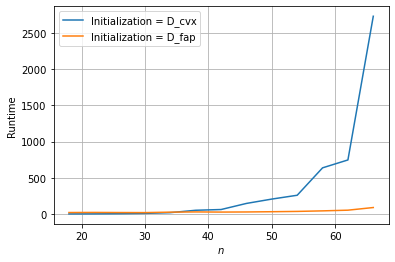

In [18]:
plt.plot(N, CVX_runtime_list,label="Initialization = D_cvx")
plt.plot(N, FAP_runtime_list, label="Initialization = D_fap")
plt.xlabel(r'$n$')
plt.ylabel('Runtime')
plt.grid()
plt.legend()
#plt.show()
#plt.close()
plt.savefig('Runtime with different n.eps', dpi=500)